Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [844]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime, timezone
import csv
from sklearn import svm
import sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

In [869]:
users = pd.read_csv('ml-users.csv')

In [870]:
# parses through each user's csv and figures out how many unique panos and missions seen
user_panos = {}
user_missions = {}
for current_user in users['user_id']:
    df_current = pd.read_csv('{0}.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
    user_missions[current_user] = df_current['mission_id'].nunique()
df_current = None

In [871]:
display(user_panos)
display(user_missions)

{'0e1ae564-6d72-4670-98e4-71369cc5ab26': 11241,
 '1353d168-ab49-4474-ae8a-213eb2dafab5': 1973,
 '2d9009b3-55d5-4aa8-a17a-a7c80afc4d51': 7349,
 '35872a6c-d171-40d9-8e66-9242b835ea71': 1085,
 '49723673-044d-4b47-855b-3bdebfe37073': 6624,
 '54c77d0f-fc8f-4497-84d3-5e336047b17e': 707,
 '6809bd6e-605f-4861-bc49-32e52c88c675': 1324,
 '715af4d8-0f17-47c4-99c6-7ef92d94803a': 6051,
 '7b1596af-14d4-4f2b-9e4e-71b1884db836': 3221,
 '86d26e9d-010f-4802-88ba-680ae0a8e20d': 2135,
 '87833d72-b357-4e2c-81cd-23f58ff04c59': 652,
 '8a471c0f-fa81-4c57-9b65-bd04a92c6a5e': 640,
 '9005a64a-fa73-4c84-b08b-b61eece1b9b7': 596,
 '939b6faa-0b57-4160-bcc2-d11fd2b69d9f': 827,
 '9b595ba6-529b-4d37-93d7-dd189184e15a': 249,
 'ac272eb8-3bb3-4260-9960-8e6c463f3867': 1239,
 'af812204-1521-4c42-bf88-4baaaffe3f06': 7792,
 'bb64c416-b0bb-4a5b-b369-00f2a56fea3a': 2482,
 'bca24c1a-a6b1-4625-ab8e-9ff8693022d7': 5496,
 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b': 4148,
 'c7190807-b56e-40c5-b96e-49dc8368328c': 422,
 'd3636d4c-2d16-410

{'0e1ae564-6d72-4670-98e4-71369cc5ab26': 364,
 '1353d168-ab49-4474-ae8a-213eb2dafab5': 64,
 '2d9009b3-55d5-4aa8-a17a-a7c80afc4d51': 243,
 '35872a6c-d171-40d9-8e66-9242b835ea71': 42,
 '49723673-044d-4b47-855b-3bdebfe37073': 219,
 '54c77d0f-fc8f-4497-84d3-5e336047b17e': 29,
 '6809bd6e-605f-4861-bc49-32e52c88c675': 45,
 '715af4d8-0f17-47c4-99c6-7ef92d94803a': 198,
 '7b1596af-14d4-4f2b-9e4e-71b1884db836': 103,
 '86d26e9d-010f-4802-88ba-680ae0a8e20d': 75,
 '87833d72-b357-4e2c-81cd-23f58ff04c59': 34,
 '8a471c0f-fa81-4c57-9b65-bd04a92c6a5e': 21,
 '9005a64a-fa73-4c84-b08b-b61eece1b9b7': 23,
 '939b6faa-0b57-4160-bcc2-d11fd2b69d9f': 34,
 '9b595ba6-529b-4d37-93d7-dd189184e15a': 11,
 'ac272eb8-3bb3-4260-9960-8e6c463f3867': 45,
 'af812204-1521-4c42-bf88-4baaaffe3f06': 257,
 'bb64c416-b0bb-4a5b-b369-00f2a56fea3a': 83,
 'bca24c1a-a6b1-4625-ab8e-9ff8693022d7': 184,
 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b': 132,
 'c7190807-b56e-40c5-b96e-49dc8368328c': 21,
 'd3636d4c-2d16-410c-bf44-c066ecaf1c31': 43,
 '

In [245]:
user_times = pd.read_csv('user_times.csv')

In [946]:
# parses through each user's csv and figures out the total time spent labeling based off of
# start and end time of a mission
# I don't think my time calculations are corrected based off of the graphs I had produced
# with the information, it seems like too little actions are happening per time period
temp = {}
current_times = []
current_mission = ''
time_total = 0
#for current_user in users['user_id']:
current_user = 'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c'
df_current = pd.read_csv('{0}.csv'.format(current_user))
for index, time in enumerate(df_current['timestamp']):
#     if index < 10000:
#         display(time)
    if time.count(':') == 1:
            time = '00:'+ time
    if df_current['mission_id'].iloc[index] != current_mission:
        if len(current_times) > 0:
            time_total = time_total + (max(current_times) - min(current_times))
        display(time)
        current_times = [(datetime.now(timezone.utc) - parser.parse(time)).total_seconds()]
        current_mission = df_current['mission_id'].iloc[index]
    else:
        current_times.append((datetime.now(timezone.utc) - parser.parse(time)).total_seconds())
    temp[current_user] = time_total

In [138]:
# Creates a csv of the total amount of time that the 
time_header = ['user_id', 'total_time_spent']
with open('user_times.csv', 'w', newline = '') as new_user:
    writer = csv.writer(new_user)
    writer.writerow(time_header)
with open('user_times.csv', 'a', newline = '') as edit_user:
    editor = csv.writer(edit_user)
    for entry in user_times.keys():
        editor.writerow([entry, user_times[entry]])

In [204]:
# df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
# #df_interactions = pd.read_csv('ml-interactions15000.csv')

# # Do a little cleanup...
# # In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# # not happen. So, let's find that row (and others) that have this problem and remove them

# # pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# # row and the value corresponds to True/False indicating whether there is a NaN value
# isna_result = pd.isna(df_interactions['action'])

# print("Printing all rows where 'action' == NaN...")
# display(df_interactions[isna_result])
# df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# # As a test, we can again look for NaN 'action' cells
# isna_result = pd.isna(df_interactions['action'])
# print("Printing all rows where 'action' == NaN... there should be no rows")
# display(df_interactions[isna_result])

# small represents the first 50000 actions logged to be able to test a smaller subset
# small= df_interactions[:50000]

In [763]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [772]:
# Parses through the csv and creates new csv for every user_id & event
with open('ml-interactions 2.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
    users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
            users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [775]:
# # This fucntion iterates over the desired dataset and returns all of the logged events
# # that contains the desired action
# def find_action(args, use_subset = False):        
#     for index, word in enumerate(args):  
#         if use_subset:
#             if index == 0:
#                 df_information = small[small['action'].str.contains(word)]
#             else:
#                 frames = [df_information, small[small['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#         else:
#             if index == 0:
#                 df_information = df_interactions[df_interactions['action'].str.contains(word)]
#             else:
#                 frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
#                 df_information = pd.concat(frames)
#     return df_information

In [875]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission. Time graph determines if it is measured by minute
# Unsure why but when measuring time, the user fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c has
# a way higher value than all other users, unsure why
def counting_graph (info_type, graph_type, multi_plot, action, time, period):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    time_period = 1
    if period == 'Minutes':
        time_period = 60
    elif period == 'Hours':
        time_period = 3600
    for index, current_id in enumerate(df_actions_grouped.groups):
        users_index = (users['user_id'] == current_id).idxmax()
        if time and index < 15:
            user_information[current_id] = len(df_actions_grouped.get_group(current_id)) / (user_times['total_time_spent'][users_index] / time_period), users['accuracy'][users_index]
        elif not time:
            user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users['accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index]
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot, time, period)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [184]:
# def time_graph (info_type, multi_plot, action):
#     user_information = {}
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     for index, current_id in enumerate(df_actions_grouped.groups):
#         users_index = (users['user_id'] == current_id).idxmax()
#         user_information[current_id] = len(df_actions_grouped.get_group(current_id)) / (user_times[current_id] / 60), users[' accuracy'][users_index]
#     for index, current_user in enumerate(users['user_id']):
#         if current_user not in user_information:
#             user_information[current_user] = 0, users[' accuracy'][index]
#     scatter_plot(info_type, user_information, multi_plot, True)

In [511]:
# def range_graph(info_type, graph_type, column):
#     user_information = {}
#     for index, current_id in enumerate(users['user_id']):
#         df_current_user = pd.read_csv('{0}.csv'.format(current_id))
#         user_information[current_id] = df_current_user[column].mean(), users[' accuracy'][index]
#     if graph_type == 'scatter_plot' :
#         scatter_plot(info_type, user_information, False, False, None)

In [945]:
# Finds the average pitch, how far up or down the users is usally looking
user_information = {}
for index, current_id in enumerate(users['user_id']):
    display(current_id)
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    current_user_panos = []
    current_pano = ''
    average_per_panos = 0
    for index_second, current in enumerate(df_current_user['pitch']):
        if index_second != 0:
            if index_second == 1:
                current_pano = df_current_user['gsv_panorama_id'][index_second]
            if df_current_user['gsv_panorama_id'][index_second] == current_pano:
                current_user_panos.append(current)
            else:
                if average_per_panos == 0:
                    average_per_panos = sum(current_user_panos) / float(len(current_user_panos))
                else:
                    average_per_panos = (average_per_panos + sum(current_user_panos) / float(len(current_user_panos))) / 2
    user_information[current_id] = df_current_user['pitch'].mean(), users['accuracy'][index], average_per_panos
scatter_plot('Average Pitch', user_information, True, False, None)

In [27]:
# # Determines the average time it takes for a certain action to occur per second and per
# # either panos or mission
# # The type of information is found using the action logged
# # Currently takes too long and doesn't run all the way, even when only processing only 
# # Per panos or per mission
# def time_graph(info_type, action):
#     df_info = pd.read_csv('{0}.csv'.format(action))
#     df_per_pano = df_info.groupby(['user_id', 'gsv_panorama_id'])
#     df_per_mission = df_info.groupby(['user_id','mission_id'])
#     user_info = {}
#     current_group_times = []
#     for name,group_pano in df_per_pano:
#         for current_datetime in group_pano['timestamp']:
#             current_group_times.append(parser.parse(current_datetime))
#         if name[0] in user_info:
#             user_info[name[0]] = user_info[name[0]][0] + (max(current_group_times) - min(current_group_times)).total_seconds(), 0
#         else:
#             user_info[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds(), 0
#     for name,group_mission in df_per_mission:
#         for current_datetime in group_mission['timestamp']:
#             current_group_times.append(parser.parse(current_datetime))
#         user_info[name[0]][1] = user_info[name[0]][1] + (max(current_group_times) - min(current_group_times)).total_seconds()
#     time_scatter_plot(info_type, user_info)

In [29]:
# def time_graph(info_type, action):
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     user_info = {}
#     current_pano_times = []
#     current_mission_times = []
#     current_pano = ''
#     current_mission = ''
#     pano_time_total = 0
#     mission_time_total = 0
#     count = 0
#     for name, current_group in df_actions_grouped:
#         for index, time in enumerate(current_group['timestamp']):
# #             if count < 1:
# #                 count += 1
# #                 display(current_group['gsv_panorama_id'])
# #                 display(current_group['gsv_panorama_id'].keys())
#             if current_group['gsv_panorama_id'].index[index] != current_pano:
#                 if len(current_pano_times) > 0:
#                     pano_time_total = pano_time_total + (max(current_pano_times) - min(current_pano_times))
#                 current_pano_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())
#                 current_pano = current_group['gsv_panorama_id'].index[index]
#             else:
#                 read_time = (parser.parse(time) - datetime.now(timezone.utc)).total_seconds()
#                 current_pano_times.append(read_time)
#             if current_group['mission_id'].index[index] != current_mission:
#                 if len(current_mission_times) > 0:
#                     mission_time_total = mission_time_total + (max(current_mission_times) - min(current_mission_times))
#                 current_mission_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())
#                 current_mission = current_group['mission_id'].index[index]
#             else:
#                 current_mission_times.append((parser.parse(time) - datetime.now(timezone.utc)).total_seconds())  
#         user_info[name] = pano_time_total, mission_time_total
# #     time_scatter_plot(info_type, user_info)

In [6]:
# def time_graph(info_type, action):
#     df_information = pd.read_csv('{0}.csv'.format(action))
#     df_actions_grouped = df_information.groupby(['user_id'])
#     user_info = {}
#     for name, current_group in df_actions_grouped:
#         current_times = []
#         current_mission = ''
#         time_total = 0
#         for index, time in enumerate(current_group['timestamp']):
#             if current_group['mission_id'].iloc[index] != current_mission:
#                 if len(current_times) > 0:
#                     time_total = time_total + (max(current_times) - min(current_times))
#                 current_times = [(datetime.now(timezone.utc) - parser.parse(time)).total_seconds()]
#                 current_mission = current_group['mission_id'].iloc[index]
#             else:
#                 current_times.append((datetime.now(timezone.utc) - parser.parse(time)).total_seconds())  
#         user_info[name] = time_total
#     time_scatter_plot(info_type, user_info)

In [147]:
# # Creates a scatter plot relating accuracy and the occurance of an action per second per
# # panos or mission
# def time_scatter_plot(info_type, user_info, multi_plot):
#     f, axs = plt.subplots(1,2,figsize=(12,4))
#     plt.subplot(122)
#     plt.ylabel('User Accuracy')
#     plt.xlabel(info_type + ' per second per Pano')
#     for index, entry in enumerate(user_info.keys()):
#         current_info = user_info.get(entry)
#         info = float(current_info[0])
#         accuracy = users[' accuracy'][index]
#         if accuracy > 65:
#             plt.plot(info, accuracy, '.', color = 'blue')
#         else:
#             plt.plot(info, accuracy, '.', color = 'red')
#     plt.subplot(121)
#     plt.ylabel('User Accuracy')
#     plt.xlabel(info_type + ' per second per Mission Started')
#     for index, entry in enumerate(user_info.keys()):
#         current_info = user_info.get(entry)
#         info = float(current_info[1])
#         accuracy = users[' accuracy'][index]
#         if accuracy > 65:
#             plt.plot(info, accuracy, '.', color = 'blue')
#         else:
#             plt.plot(info, accuracy, '.', color = 'red')

In [874]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, multi_plot, per_time, period):
    if multi_plot:
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        if per_time:
            plt.xlabel(info_type + ' per ' + period + ' per Pano')
        else:
            plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            if accuracy > 65:
                plt.plot(info, accuracy, '.', color = 'blue')
            else:
                plt.plot(info, accuracy, '.', color = 'red')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        if per_time:
            plt.xlabel(info_type + ' per ' + period + ' per Mission Started')
        else:
            plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            if accuracy > 65:
                plt.plot(info, accuracy, '.', color = 'blue')
            else:
                plt.plot(info, accuracy, '.', color = 'red')
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    if per_time:
        plt.xlabel(info_type + ' per ' + period)
    else:
        plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'blue')
        else:
            plt.plot(info, accuracy, '.', color = 'red')

In [769]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

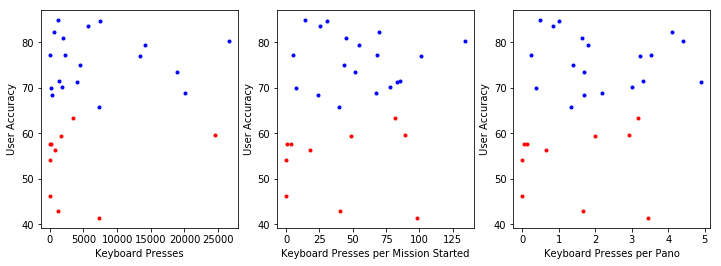

In [876]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown', False, None)

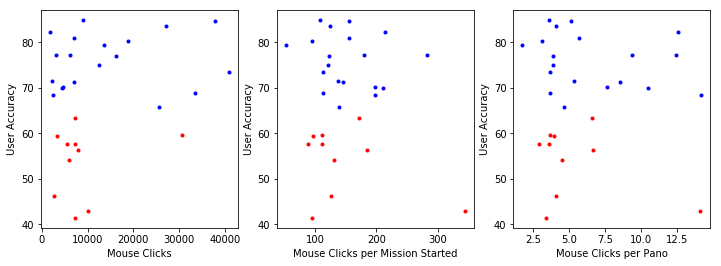

In [877]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown', False, None)

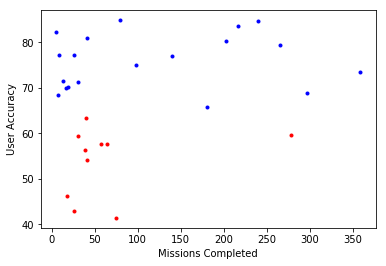

In [878]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete', False, None)

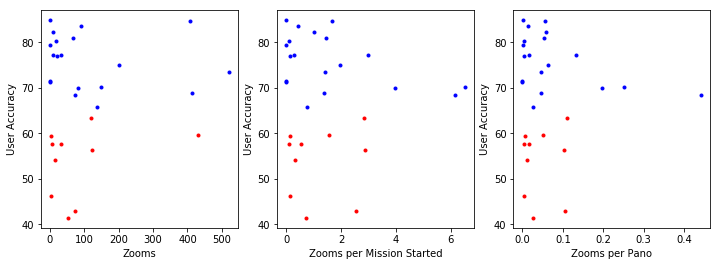

In [879]:
# Counts the number of zooms
counting_graph('Zooms', 'scatter_plot', True, 'Click_ZoomIn', False, None)

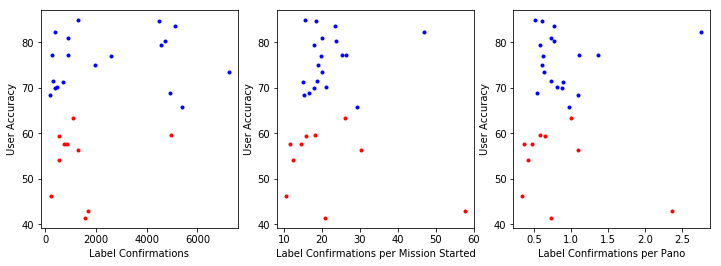

In [880]:
# Counts the number of Labels confirmations based off of time the context menu was opened
counting_graph('Label Confirmations', 'scatter_plot', True, 'ContextMenu_Open', False, None)

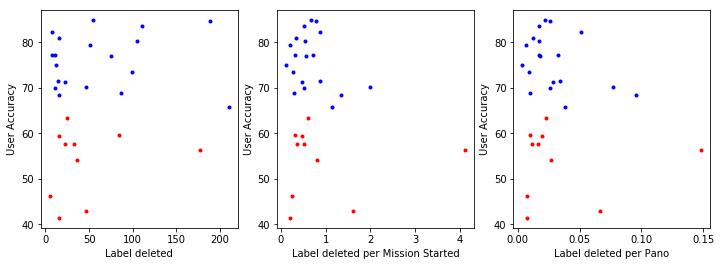

In [881]:
# Counts the number of Labels Deleted
counting_graph('Label deleted', 'scatter_plot', True, 'RemoveLabel', False, None)

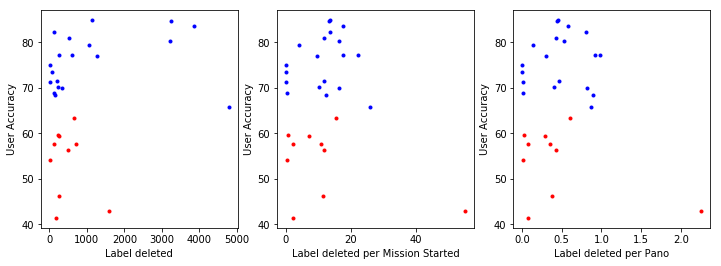

In [882]:
# Counts the number of Tags Placed
counting_graph('Label deleted', 'scatter_plot', True, 'ContextMenu_TagAdded', False, None)

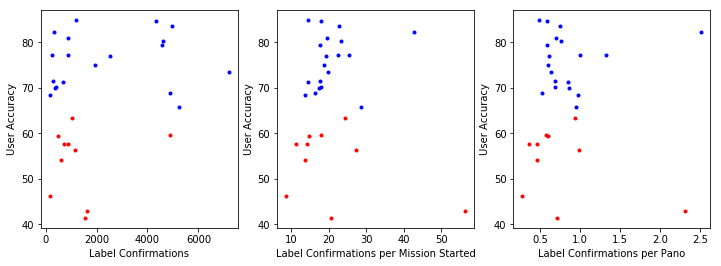

In [883]:
# Counts the number of Label Confirmation based off of closing the context window
# I am currently unsure whether this one or the one above would be a more accurate measure
# of labels done and what the other would represent
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling', False, None)

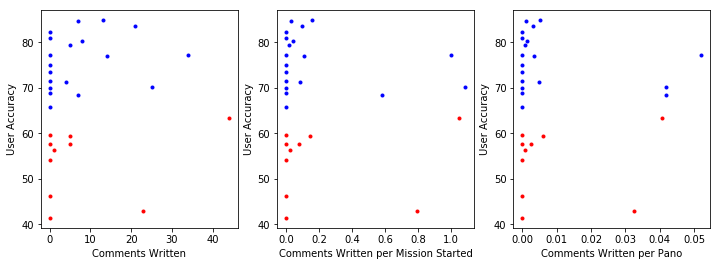

In [884]:
# Counts the number of Comments Written
# Unsure if measuring the blur of the text box is an accurate representation of comments written
counting_graph('Comments Written', 'scatter_plot', True, 'ContextMenu_TextBoxChange', False, None)

In [128]:
# # Counts the number of comments written

# user_information = {}
# df_comments = pd.read_csv('{0}.csv'.format('ContextMenu_TextBoxBlur'))
# df_window_closes = pd.read_csv('{0}.csv'.format('ContextMenu_Close'))
# df_comments_grouped = df_comments.groupby(['user_id'])
# df_window_closes_grouped = df_window_closes.groupby(['user_id'])
# for index, current_id in enumerate(df_comments_grouped.groups):
#     user_information[current_id] = len(df_comments_grouped.get_group(current_id)), users[' accuracy'][index]
# scatter_plot('Comments Written', user_information, True)

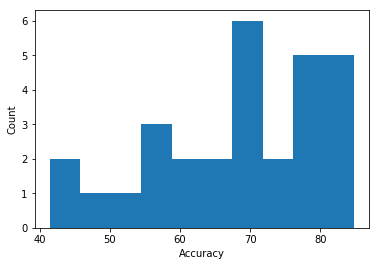

In [885]:
# Counts the number of users with different accuracies
histogram('Accuracy', users['accuracy'])

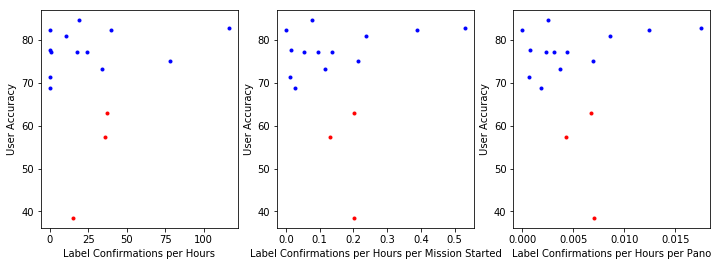

In [303]:
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling', True, 'Hours')

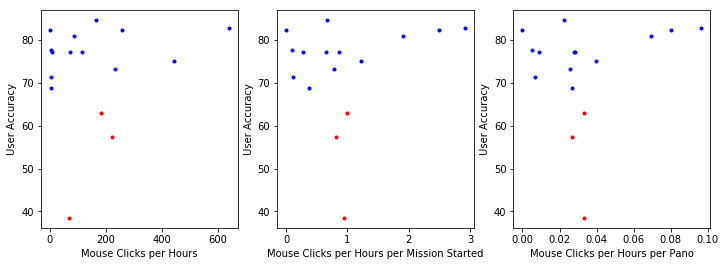

In [304]:
# Counts the number of mouse clicks per minute
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown', True, 'Hours')

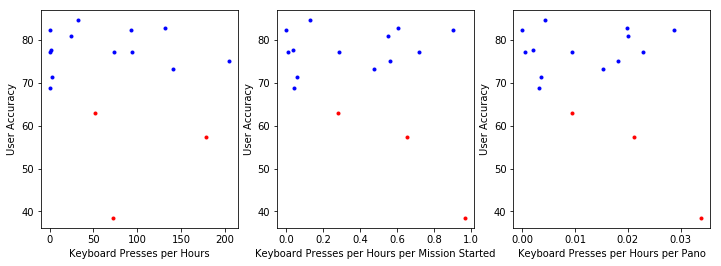

In [311]:
# Counts the number of keyboard presses per minute
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown', True, 'Hours')

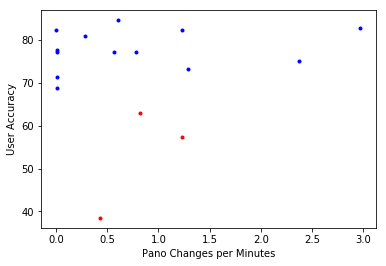

In [307]:
# Counts the number of Pano changes per minute
counting_graph('Pano Changes', 'scatter_plot', False, 'PanoId_Changed', True, 'Minutes')

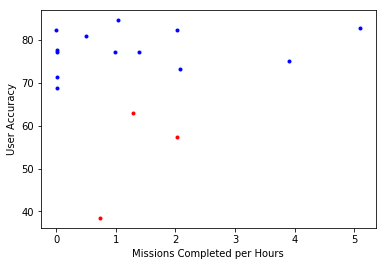

In [308]:
# Counts the number of missions completed per hour
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete', True, 'Hours')

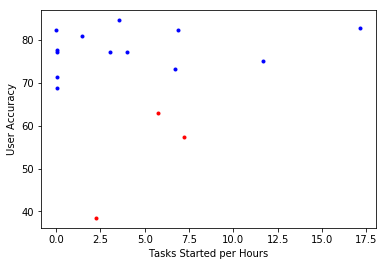

In [309]:
# Counts the number of tasks started per hour
counting_graph('Tasks Started', 'scatter_plot', False, 'TaskStart', True, 'Hours')

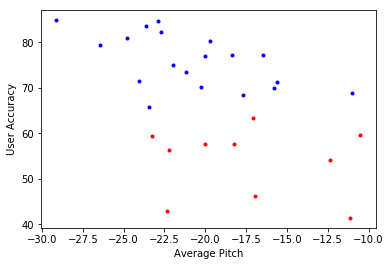

In [886]:
# Finds the average pitch, how far up or down the users is usally looking
user_information = {}
for index, current_id in enumerate(users['user_id']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    user_information[current_id] = df_current_user['pitch'].mean(), users['accuracy'][index]
scatter_plot('Average Pitch', user_information, False, False, None)

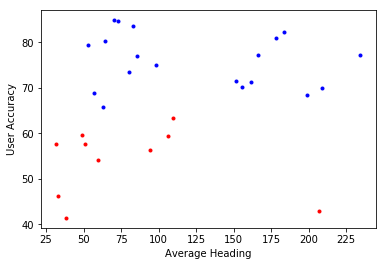

In [887]:
# Calculates the average range of how much a person looks looks side to side
user_information = {}
for index, current_id in enumerate(users['user_id']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    current_heading = []
    for current, group in df_grouped:
        current_heading.append(group['heading'].max() - group['heading'].min())
    user_information[current_id] = (sum(current_heading) / float(len(current_heading))), users['accuracy'][index]
scatter_plot('Average Heading', user_information, False, False, None)

In [892]:
test_data = []
training_data = []
feature_header = ['test']
test_id = []
training_id = []
training_output = []
test_output = []
output_header = ['Quality', 'Accuracy']
create_groups(25)

In [896]:
display(feature_header)
display(training_data)
display(test_data)
display(output_header)
display(training_output)
display(test_output)

['test', 'Average Pitch']

[[0, -21.15926586977427],
 [0, -20.037270042145735],
 [0, -22.913363875577915],
 [0, -17.094591308250653],
 [0, -23.614854446813293],
 [0, -22.372120062392113],
 [0, -12.331478498128579],
 [0, -19.731631314501747],
 [0, -22.002346829436863],
 [0, -11.129765593699345],
 [0, -18.353221092355916],
 [0, -16.949211424957806],
 [0, -20.251933147760678],
 [0, -23.2755191231088],
 [0, -16.466069077943907],
 [0, -24.77485008470693],
 [0, -26.430964053074543],
 [0, -29.14317321088398],
 [0, -23.448291696073824],
 [0, -20.006998023888862],
 [0, -15.818322032082976],
 [0, -22.239289338792325],
 [0, -17.666648998052956],
 [0, -24.075948967466726],
 [0, -15.612335016121987]]

[[0, -10.498907626361033],
 [0, -11.0338256228948],
 [0, -18.239756104119156],
 [0, -22.705144524571313]]

['Quality', 'Accuracy']

[['1', 73.42657342657343],
 ['0', 57.608695652173914],
 ['1', 84.68085106382978],
 ['0', 63.34164588528678],
 ['1', 83.49917081260365],
 ['0', 42.857142857142854],
 ['0', 54.11764705882353],
 ['1', 80.2734375],
 ['1', 74.93975903614458],
 ['0', 41.43302180685358],
 ['1', 77.26980038634899],
 ['0', 46.15384615384615],
 ['1', 70.1923076923077],
 ['0', 59.32203389830509],
 ['1', 77.19780219780219],
 ['1', 80.9322033898305],
 ['1', 79.46257197696737],
 ['1', 84.82758620689654],
 ['1', 65.80027359781121],
 ['1', 76.90476190476191],
 ['1', 69.91150442477877],
 ['0', 56.41025641025641],
 ['1', 68.4931506849315],
 ['1', 71.42857142857143],
 ['1', 71.3015873015873]]

[['0', 59.68882602545968],
 ['1', 68.8],
 ['0', 57.692307692307686],
 ['1', 82.17573221757323]]

In [897]:
add_feature(None, 'heading', 'Average Heading Range', False)

In [890]:
# Creates a lists of each user's outputs (Quality 0 = Bad, 1 = Good, and accuracy)
# Also creates an list for features
def create_groups(number_of_training):
    for index, entry in enumerate(users['user_id']):
        current_accuracy = users['accuracy'][index]
        if current_accuracy <= 65:
            quality = '0'
        else:
            quality = '1'
        if index < number_of_training:
            training_output.append([quality, current_accuracy])
            training_data.append([0])
            training_id.append(entry)
        else:
            test_output.append([quality, current_accuracy])
            test_data.append([0])
            test_id.append(entry)

In [891]:
# Adds a feature into the features list of both the training and testing model
def add_feature(feature, info_type, feature_title, multi):
    if feature_title not in feature_header:
        if multi:
            feature_header.append(feature_title + ' per Panos')
            feature_header.append(feature_title + ' per Mission')
        else:
            feature_header.append(feature_title)
        for index, entry in enumerate(users['user_id']):
            df_user = pd.read_csv('{0}.csv'.format(entry))
            action_count = df_user['action'].value_counts()
            if feature in action_count:
                #if info_type == 'count':
                panos =  action_count[feature] / float(user_panos[entry])
                missions = action_count[feature] / float(user_missions[entry])
                if info_type == 'time':
                    panos =  panos / user_times[entry]
                    missions = missions / user_times[entry]
            elif info_type == 'pitch':
                info = df_user['pitch'].mean()     
            elif info_type == 'heading':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                current_heading = []
                for current, group in df_grouped:
                    current_heading.append(group['heading'].max() - group['heading'].min())
                info = (sum(current_heading) / float(len(current_heading)))      
            else:
                panos = 0
                missions = 0
            if multi:
                if entry in training_id:
                    current_index = training_id.index(entry)
                    training_data[current_index].append(panos)
                    training_data[current_index].append(missions)
                else:
                    current_index = test_id.index(entry)
                    test_data[current_index].append(panos)
                    test_data[current_index].append(missions)
            else:
                if entry in training_id:
                    current_index = training_id.index(entry)
                    training_data[current_index].append(info)
                else:
                    current_index = test_id.index(entry)
                    test_data[current_index].append(info)

In [912]:
# Creates dataframes of all of the lists (features, outputs, combied)
df_test = pd.DataFrame(test_data, columns = feature_header, index = test_id)
df_training = pd.DataFrame(training_data, columns = feature_header, index = training_id)
df_test_output = pd.DataFrame(test_output, columns = output_header, index = test_id)
df_training_output = pd.DataFrame(training_output, columns = output_header, index = training_id)
df_joined_training = df_training.join(df_training_output)
df_joined_test = df_test.join(df_test_output)

In [903]:
print('test')
display(df_test)
print('training')
display(df_training)
print('test outputs')
display(df_test_output)
print('training outputs')
display(df_training_output)

test


,test,Average Pitch,Average Heading Range
ec15a589-dd14-4513-a43e-8c06e55f4c71,0,-10.498908,48.859672
f13d2630-35fd-4a78-883d-d108be083425,0,-11.033826,56.778802
f5314ef9-3877-438c-ba65-ee2a2bbbf7f5,0,-18.239756,31.668148
fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c,0,-22.705145,183.747194


training


,test,Average Pitch,Average Heading Range
0e1ae564-6d72-4670-98e4-71369cc5ab26,0,-21.159266,80.602521
1353d168-ab49-4474-ae8a-213eb2dafab5,0,-20.037270,51.053598
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,0,-22.913364,72.750053
35872a6c-d171-40d9-8e66-9242b835ea71,0,-17.094591,109.923155
49723673-044d-4b47-855b-3bdebfe37073,0,-23.614854,82.709347
54c77d0f-fc8f-4497-84d3-5e336047b17e,0,-22.372120,207.116265
6809bd6e-605f-4861-bc49-32e52c88c675,0,-12.331478,59.582813
715af4d8-0f17-47c4-99c6-7ef92d94803a,0,-19.731631,64.251512
7b1596af-14d4-4f2b-9e4e-71b1884db836,0,-22.002347,98.297571
86d26e9d-010f-4802-88ba-680ae0a8e20d,0,-11.129766,38.040449


test outputs


,Quality,Accuracy
ec15a589-dd14-4513-a43e-8c06e55f4c71,0,59.688826
f13d2630-35fd-4a78-883d-d108be083425,1,68.800000
f5314ef9-3877-438c-ba65-ee2a2bbbf7f5,0,57.692308
fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c,1,82.175732


training outputs


,Quality,Accuracy
0e1ae564-6d72-4670-98e4-71369cc5ab26,1,73.426573
1353d168-ab49-4474-ae8a-213eb2dafab5,0,57.608696
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,1,84.680851
35872a6c-d171-40d9-8e66-9242b835ea71,0,63.341646
49723673-044d-4b47-855b-3bdebfe37073,1,83.499171
54c77d0f-fc8f-4497-84d3-5e336047b17e,0,42.857143
6809bd6e-605f-4861-bc49-32e52c88c675,0,54.117647
715af4d8-0f17-47c4-99c6-7ef92d94803a,1,80.273438
7b1596af-14d4-4f2b-9e4e-71b1884db836,1,74.939759
86d26e9d-010f-4802-88ba-680ae0a8e20d,0,41.433022


In [938]:
# SVM Classifier model
clf = svm.SVC(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training, df_training_output['Quality'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [925]:
# SVM Regression Model
clf = svm.SVR(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training, df_training_output['Accuracy'])

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [816]:
# Tree Classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_training, df_training_output['Quality'])

In [825]:
# Tree Regressor
clf = tree.DecisionTreeRegressor()
clf = clf.fit(df_training, df_training_output['Accuracy'])

In [744]:
# Removing features with low variance
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_training_new = selector.fit_transform(df_training)
df_test_new = selector.transform(df_test)

In [935]:
# SVM SelectFromModel feature selection
selector = SelectFromModel(clf, prefit = True)
df_training_new = selector.transform(df_training)

In [942]:
# Tree Classifier SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(df_training, df_training_output['Quality'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training_new = selector.transform(df_training)

In [931]:
# Tree Regressor SelectFromModel
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(df_training, df_training_output['Accuracy'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training_new = selector.transform(df_training)

In [943]:
clf.score(df_test, df_test_output['Quality'])

0.75

In [944]:
# Test for the svm models
clf.predict(df_test)

array(['0', '0', '0', '1'], dtype=object)

In [936]:
display(df_training_new)

array([[-21.15926587,  80.60252065],
       [-20.03727004,  51.05359774],
       [-22.91336388,  72.75005308],
       [-17.09459131, 109.92315493],
       [-23.61485445,  82.70934696],
       [-22.37212006, 207.1162646 ],
       [-12.3314785 ,  59.582813  ],
       [-19.73163131,  64.25151153],
       [-22.00234683,  98.29757135],
       [-11.12976559,  38.04044879],
       [-18.35322109, 166.08346594],
       [-16.94921142,  32.88121308],
       [-20.25193315, 155.5893069 ],
       [-23.27551912, 106.10147228],
       [-16.46606908, 234.49434241],
       [-24.77485008, 178.09136432],
       [-26.43096405,  52.66662288],
       [-29.14317321,  70.34913129],
       [-23.4482917 ,  63.12952124],
       [-20.00699802,  85.67185736],
       [-15.81832203, 209.10276806],
       [-22.23928934,  94.36452846],
       [-17.666649  , 199.11119076],
       [-24.07594897, 151.63527289],
       [-15.61233502, 161.54052   ]])

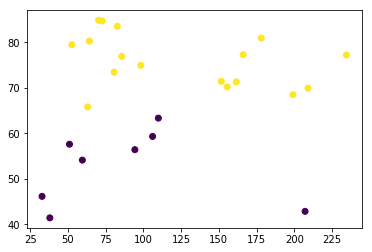

In [916]:

plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_training, c = (df_joined_training['Quality'] == '1'))

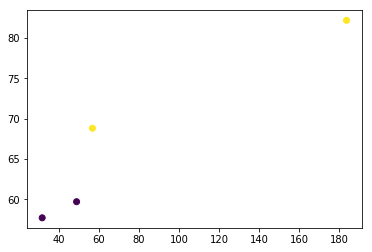

In [918]:
# Shows Test Data
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_test, c = (df_joined_test['Quality'] == '1'))

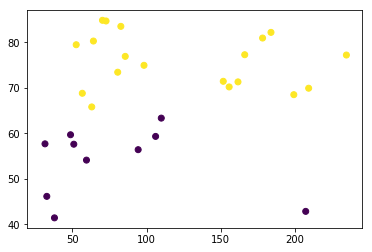

In [919]:
# Shows all data
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_training, c = (df_joined_training['Quality'] == '1'))
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_test, c = (df_joined_test['Quality'] == '1'))

In [313]:
df_finished_labeling = pd.read_csv('LabelingCanvas_FinishLabeling.csv')
df_all_labels = pd.read_csv('ml-label-correctness.csv')

In [329]:
df_finished_labeling.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.drop(columns=('user_id'), inplace=True)

In [388]:
df_joined = df_finished_labeling.join(df_all_labels)
df_joined = df_joined[~pd.isna(df_joined['correct'])]
df_joined = df_joined[df_joined['lat'] > 46]
df_joined.to_csv('all_labels.csv', encoding='utf-8', index=False)

In [385]:
# Creates a csv of all of the labels of each users
for current_user in users['user_id']:
    current_correctness = df_joined[df_joined['user_id'] == current_user]
    current_correctness.to_csv('{0}_correctness.csv'.format(current_user), encoding='utf-8', index=False)

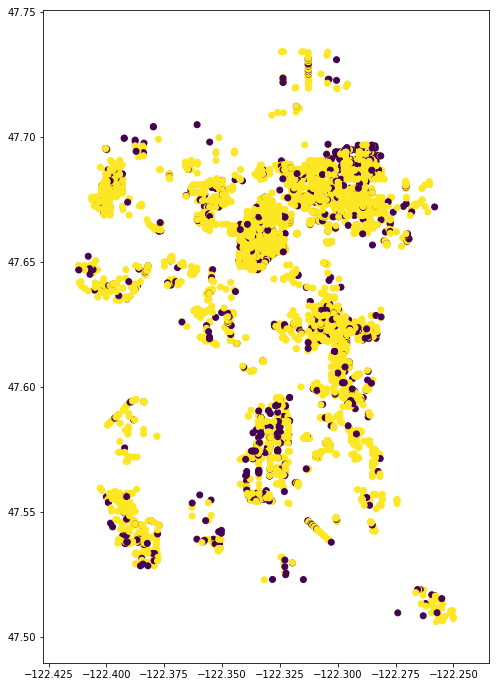

In [395]:
# Plots all validated labels
plt.figure(figsize=(8, 12))
plt.scatter(df_joined['lng'], df_joined['lat'], c = (df_joined['correct'] == 't'))